In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Test.csv -O Test.csv
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Train.csv -O Train.csv
# !wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/SampleSubmission.csv -O SampleSubmission.csv
# !pip install catboost

In [3]:
import catboost
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')
df['year'] = pd.DatetimeIndex(df.date).year - 2011
df['mohth_from_begin'] = df.year * 12 + pd.DatetimeIndex(df.date).month
df_test['year'] = pd.DatetimeIndex(df_test.date).year - 2011
df_test['mohth_from_begin'] = df_test.year * 12 + pd.DatetimeIndex(df_test.date).month

del df['date']
del df_test['date']
del df['year']
del df_test['year']
df = df.iloc[df.price.values != 1000000, :]
df['price_m2'] = df.price / df.area
df.reset_index(inplace=True)
del df['index']
del df['id']
del (df['kw8'])
del (df['kw9'])
del (df['g_lift'])
del (df_test['kw8'])
del (df_test['kw9'])
del (df_test['g_lift'])
df.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw5,kw6,kw7,kw10,kw11,kw12,kw13,price,mohth_from_begin,price_m2
0,30,0.0,10,48,2,0,30.0,4,0,1,...,0,0,0,0,0,0,0,4252000,1,88583.333333
1,376,1.0,2,53,2,0,30.0,0,0,1,...,0,0,0,0,0,0,0,4463000,1,84207.547170
2,549,NaN,8,61,3,1,30.0,1,0,0,...,0,0,0,0,0,0,0,4518000,1,74065.573770
3,321,1.0,10,47,1,1,30.0,6,0,1,...,0,0,0,0,0,0,0,6785000,1,144361.702128
4,636,NaN,3,58,3,0,25.0,2,0,0,...,0,0,0,0,0,0,0,1677000,1,28913.793103


In [4]:
df['weights_unique'] = 0  # у квартир с одинаковой ценой вес меньше
counts = df.price.value_counts().values
values = df.price.value_counts().index.values
for i in range(values.shape[0]):
    df.weights_unique[df.price.values == values[i]] = 1 / np.cbrt(counts[i])  # веса наблюдений


df['weights_miss'] = 1  # у квартир с пропусками вес меньше
df.fillna(value=-9999, inplace=True)
df.weights_miss[df.metro_dist.values == -9999] = df.weights_miss[df.metro_dist.values == -9999] * 0.7 # предсказывается средне
df.weights_miss[df.build_tech.values == -9999] = df.weights_miss[df.build_tech.values == -9999] * 0.8  # предсказывается хорошо


df['month_weights'] = np.cbrt(df.mohth_from_begin.values)  # более поздние наблюдения имеют больший вес


df['weights'] = df.weights_unique * df.weights_miss + df.month_weights
del df['weights_miss']
del df['month_weights']
del df['weights_unique']
df_test.fillna(value=-9999, inplace=True)
df

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw6,kw7,kw10,kw11,kw12,kw13,price,mohth_from_begin,price_m2,weights
0,30,0.0,10,48,2,0,30.0,4,0,1,...,0,0,0,0,0,0,4252000,1,88583.333333,1.362460
1,376,1.0,2,53,2,0,30.0,0,0,1,...,0,0,0,0,0,0,4463000,1,84207.547170,1.449644
2,549,-9999.0,8,61,3,1,30.0,1,0,0,...,0,0,0,0,0,0,4518000,1,74065.573770,1.349432
3,321,1.0,10,47,1,1,30.0,6,0,1,...,0,0,0,0,0,0,6785000,1,144361.702128,1.522758
4,636,-9999.0,3,58,3,0,25.0,2,0,0,...,0,0,0,0,0,0,1677000,1,28913.793103,1.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95988,327,0.0,9,37,1,0,25.0,1,0,1,...,0,0,0,0,0,0,3198000,15,86432.432432,2.855123
95989,249,0.0,2,33,1,0,20.0,1,0,1,...,0,0,0,0,0,0,2366000,15,71696.969697,2.903002
95990,537,-9999.0,3,61,3,0,30.0,6,1,1,...,0,0,0,0,0,0,3816000,15,62557.377049,2.743557
95991,425,1.0,4,35,1,1,10.0,2,0,1,...,0,0,0,0,0,0,3410000,15,97428.571429,2.823095


Заполняю build_tech

In [5]:
from catboost import CatBoostClassifier 
from catboost import Pool

mask = df.build_tech.values != -9999
features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']
train_pool = Pool(data=df[features][mask], label=df.build_tech[mask].values, cat_features=cat_features, weight = df.weights[mask].values)
build_model = CatBoostClassifier(random_state=42)
build_model.fit(train_pool, verbose = False)
pred_train = build_model.predict(train_pool)


In [6]:
df.build_tech[df.build_tech.values == -9999] = build_model.predict(df[df.build_tech.values == -9999][features].values).reshape(-1)
df_test.build_tech[df_test.build_tech == -9999] = build_model.predict(df_test[df_test.build_tech.values == -9999][features].values).reshape(-1)

Заполняю metro_dist

In [7]:
from catboost import CatBoostRegressor

mask = df.metro_dist.values != -9999
features = ['build_tech', 'street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

train_pool = Pool(data=df[features][mask], label=df.metro_dist[mask], cat_features=cat_features, weight = df.weights[mask].values)
metro_model = CatBoostRegressor(loss_function = 'MAE', eval_metric='MAE', 
                random_state=42, n_estimators=3000)
metro_model.fit(train_pool, verbose = False)

In [8]:
df.metro_dist[df.metro_dist.values == -9999] = metro_model.predict(df[df.metro_dist.values == -9999][features])
df_test.metro_dist[df_test.metro_dist == -9999] = metro_model.predict(df_test[df_test.metro_dist.values == -9999][features])

In [9]:
df.metro_dist = round(df.metro_dist / 5) * 5
df_test.metro_dist = round(df_test.metro_dist / 5) * 5

Анализирую стоймость квартир в каждом месяце

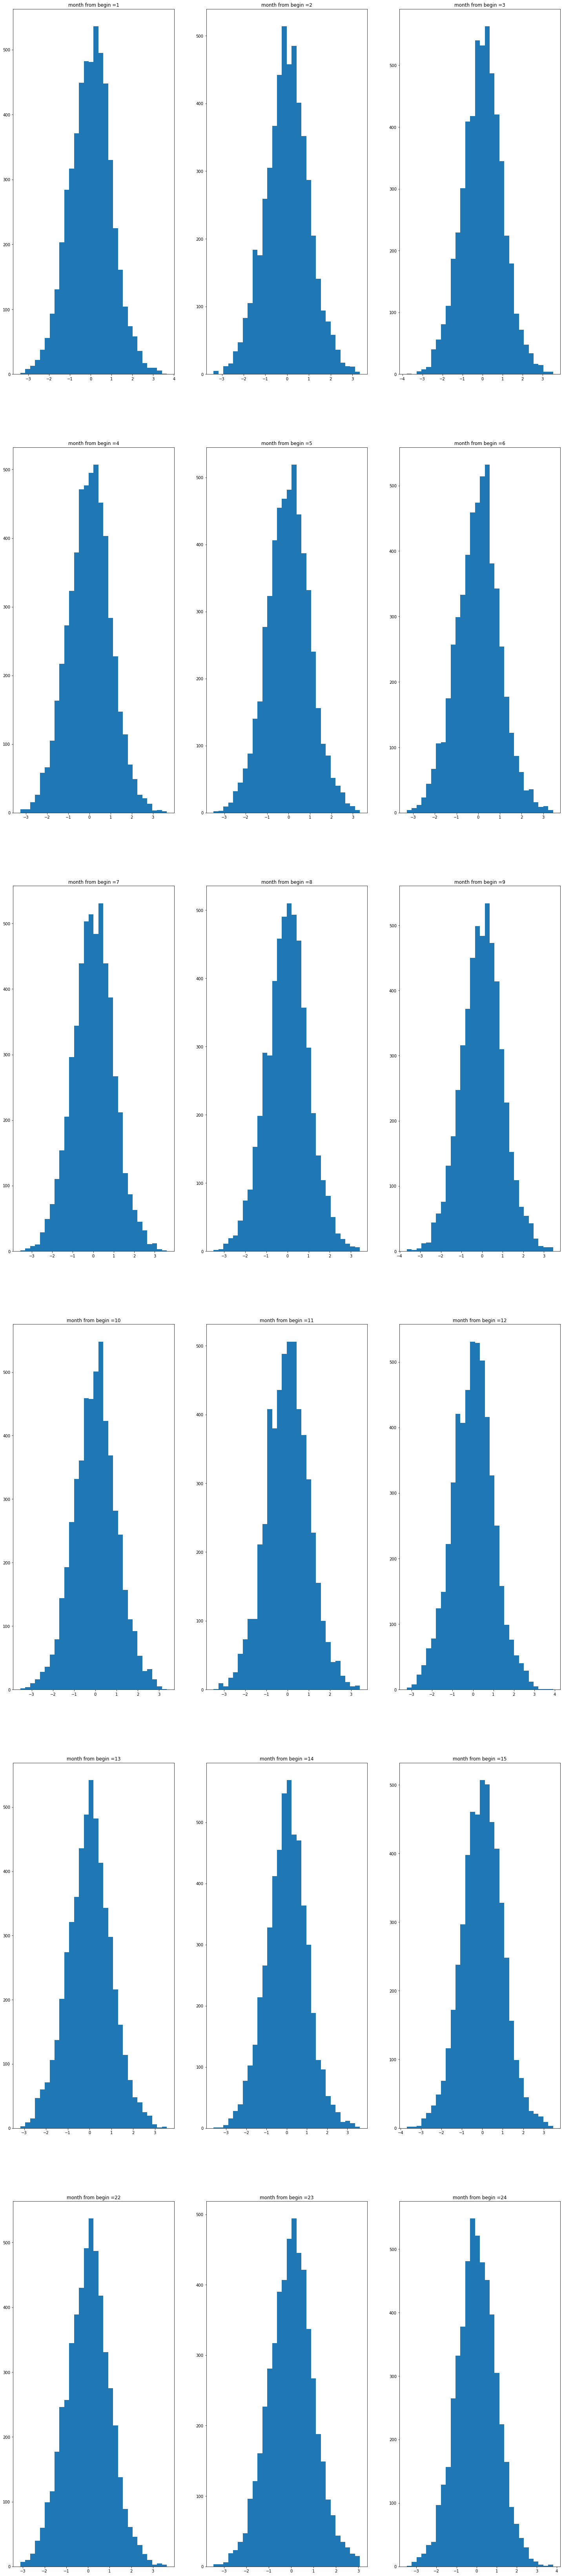

In [10]:
from sklearn.preprocessing import PowerTransformer
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_month[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Стоймость квартир в зависимости от улицы

In [11]:
street_spisok = []
y = df.street_id.values
df['normal_price_street'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_street[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)

In [12]:
df['weight_price'] = df.price * df.weights

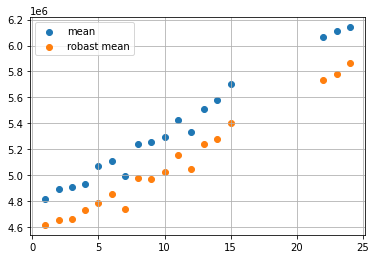

In [13]:
mean_price = df[['price', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средня цена


df['weight_price'] = df.price * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -3 3 стандартных отклонений по улицам 
mask = mask1 * mask2
robast_mean_price = df[['weight_price', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price.index, mean_price.values, label = "mean")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

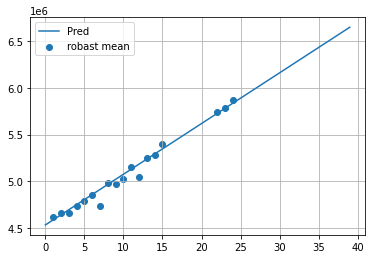

In [14]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

train = robast_mean_price
linear_model = SVR(kernel = 'poly', degree= 1, C = 1e5).fit(X = train.index.values.reshape(-1, 1), y = train.values)
pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

Вычисляю коэффицент стоймости от месяца по модели

In [15]:
time_24 = linear_model.predict([[24]]) 
df['pred_mean'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены
df['model_time_coef'] = df.pred_mean / time_24  # коэффициент стоймости от времени
df['model_price_without_time'] = df.price / df.model_time_coef  # цена с поправкой на время
df_test['model_pred_mean'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены для теста
df_test['model_time_coef'] = df_test.model_pred_mean / time_24  # опорным беру последний месяц

Стоймость квадратного метра в зависимости от даты и улицы

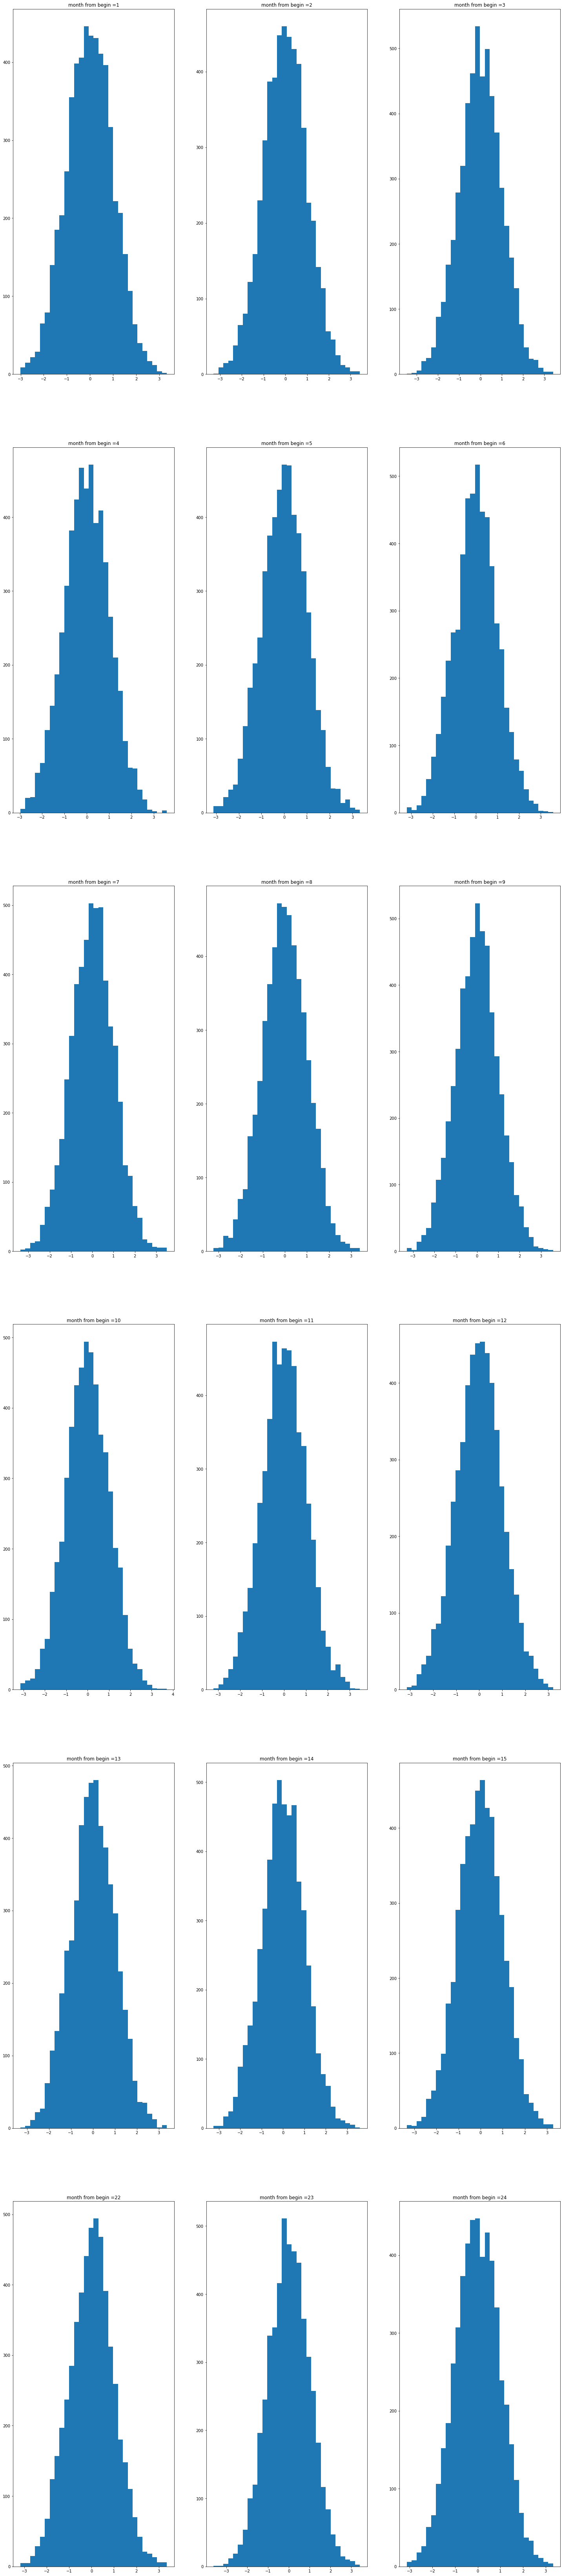

In [16]:
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_month_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month_m2[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

In [17]:
street_spisok = []
y = df.street_id.values
df['normal_price_street_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_street_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)


Считаю среднюю и робастную среднюю оценки средней цены за квадратный метр. Удивительно, но цена почему-то растет линейно. Хотя в старых данных экспонециально!!!!

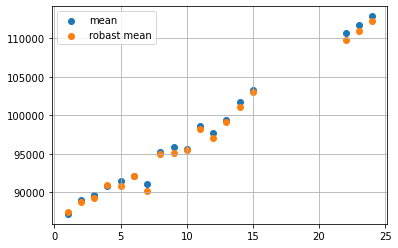

In [18]:
mean_price_m2 = df[['price_m2', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средняя цена
df['weight_price_m2'] = df.price_m2 * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -1 1 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по улицам (здесь 2 тк их выборка для каждого меньше)
mask = mask1 * mask2
robast_mean_price_m2 = df[['weight_price_m2', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price_m2.index, mean_price_m2.values, label = "mean")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

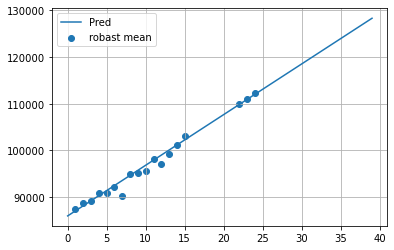

In [19]:
train = robast_mean_price_m2
linear_model = SVR(kernel = 'poly', degree = 1,  C = 10000).fit(X = train.index.values.reshape(-1, 1), y = train.values)

pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

In [20]:
time_24 = linear_model.predict([[24]])
df['model_pred_mean_m2'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))
df_test['model_pred_mean_m2'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))
df['model_coef_price_m2'] = df['price_m2'] / df['model_pred_mean_m2'] # во сколько квартира лучше средней
df['model_time_coef_m2'] = df.model_pred_mean_m2 / time_24
df['model_price_m2_without_time'] = df.price_m2 / df.model_time_coef_m2


Выполняю кластеризацию. По площади и стоймости квадратного метра с поправкой на время

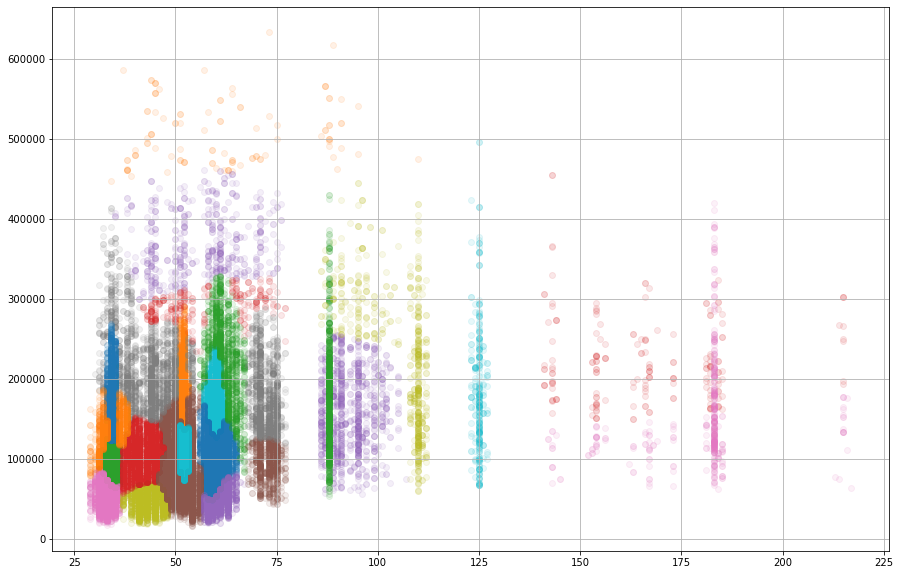

In [21]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())  # список цветов


train = df.sample(frac = 0.7, replace = True, random_state = 42, weights=df.weights)

claster = ['model_price_m2_without_time', 'area']
classtering = Pipeline([
    ('SS', StandardScaler()),
    ('GaussianMixture', GaussianMixture(n_components = 30, random_state = 42, n_init = 10)) 
])

labels = classtering.fit_predict(train[claster])


plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(labels):
    plt.scatter(train.area[i == labels].values, train.model_price_m2_without_time[i==labels].values, cmap=colors_list[i], alpha=0.1)
plt.show()

In [22]:
df['labels'] = classtering.predict(df[claster])

Предсказываю метку кластера по известным признакам

In [23]:
train, valid = train_test_split(df, train_size=0.5)
features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist','n_photos', 
           'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

target = ['labels']

train_pool = Pool(train[features], label=train[target], weight = train.weights.values)
valid_pool  =Pool(valid[features], label=valid[target])

model = CatBoostClassifier(n_estimators=2000, random_state=42,
                           auto_class_weights='SqrtBalanced'
                    
)
model.fit(train_pool, eval_set=valid_pool, verbose = False)

In [24]:
pred_train = model.predict(train_pool)
pred_valid = model.predict(valid_pool)

In [25]:
train['pred_labels'] = pred_train
valid['pred_labels'] = pred_valid

In [26]:
from sklearn.metrics import classification_report
print("train: \n", classification_report(pred_train, train.labels.values))
print("valid: \n", classification_report(pred_valid, valid.labels.values))

train: 
               precision    recall  f1-score   support

           0       0.79      0.69      0.74      6637
           1       0.72      0.70      0.71      1795
           2       0.74      0.73      0.74      4284
           3       1.00      1.00      1.00       135
           4       0.99      1.00      1.00       687
           5       0.71      0.68      0.70      1509
           6       0.76      0.79      0.78      3441
           7       0.91      0.84      0.88       530
           8       0.84      0.78      0.81      2387
           9       0.72      0.65      0.68      3322
          10       0.77      0.73      0.75      2002
          11       1.00      1.00      1.00        76
          12       1.00      1.00      1.00       578
          13       0.73      0.85      0.79      1931
          14       0.95      0.89      0.92       325
          15       0.72      0.85      0.78      4563
          16       1.00      1.00      1.00        84
          17      

Так выглядят истинные метки

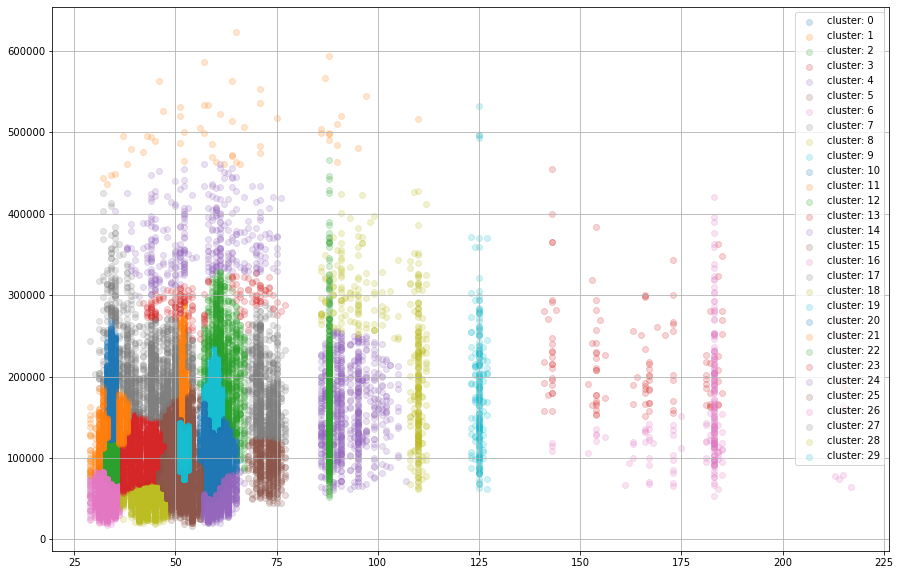

In [27]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(train.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.labels].values, valid.model_price_m2_without_time[i==valid.labels].values,
                cmap=colors_list[i], alpha=0.2, label ='cluster: ' + str(i))
plt.legend()
plt.show()

А так прогнозные

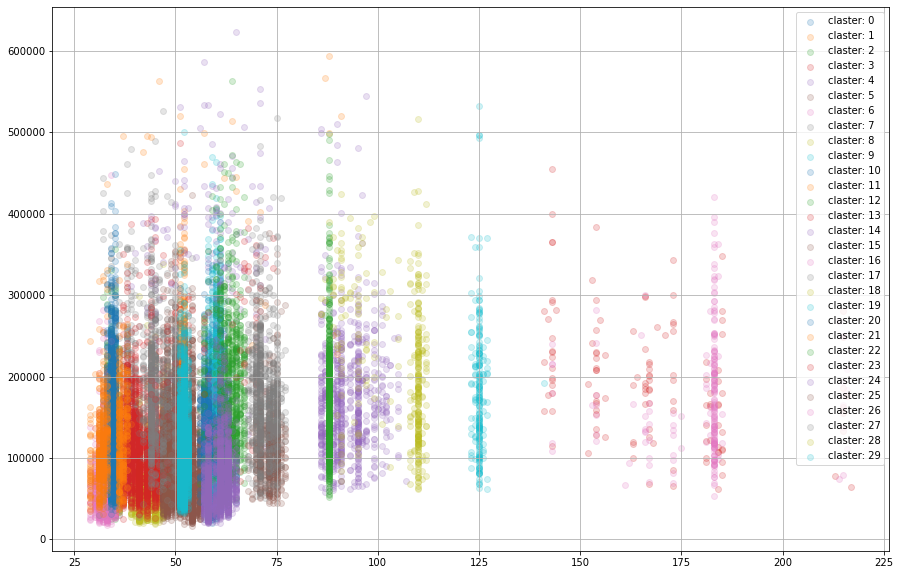

In [28]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(valid.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.pred_labels].values, valid.model_price_m2_without_time[i==valid.pred_labels].values,
                cmap=colors_list[i], alpha=0.2, label ='claster: ' + str(i))
plt.legend()
plt.show()

Финальная модель

In [29]:
df['labels'] = model.predict(df[features])
df_test['labels'] = model.predict(df_test[features])

In [30]:
labels = ['labels'] 
initial_features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'kw1', 'kw2']
cat_features_ = ['street_id']

target = ['model_price_without_time']

cat_features = cat_features_  #+ labels

features = initial_features  #+ labels


train_pool = Pool(data = df[features], label = df[target], cat_features=cat_features)

In [32]:
model = CatBoostRegressor(random_state=42, n_estimators = 15000, loss_function='MAE', eval_metric = 'MAE',
                          bagging_temperature =  0.43, depth=6, l2_leaf_reg = 299, learning_rate = 0.056,
                        #  task_type = 'GPU'
#                           rsm = 0.6
                         ) 
model.fit(train_pool, verbose = False)                      
                
# pred_train = model.predict(df_train[features])
# pred_valid = model.predict(df_valid[features])
# pred_test = model.predict(df_test[features])

In [33]:
dict(zip(model.feature_names_, model.feature_importances_))

{'street_id': 33.19203196232072,
 'build_tech': 8.380940515899905,
 'floor': 3.383818633627702,
 'area': 44.97865436927083,
 'rooms': 5.852320889700162,
 'balcon': 0.373830044889124,
 'metro_dist': 3.310667754782244,
 'kw1': 0.25823730841898207,
 'kw2': 0.2694985210902142}

In [ ]:
df_test['result_price'] = model.predict(df_test[features])  * df_test.model_time_coef

без меток получилось лучше на 6к, возможно переобучился

In [ ]:
sub = pd.read_csv('SampleSubmission.csv')
sub.price = df_test.result_price
sub.to_csv("submit_no_labels1.csv", index = False)